C:\Users\leewa\AppData\Local\Temp\ipykernel_14288\3597321363.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\leewa\AppData\Local\Temp\ipykernel_14288\3597321363.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
c:\Users\leewa\anaconda3\a cute anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


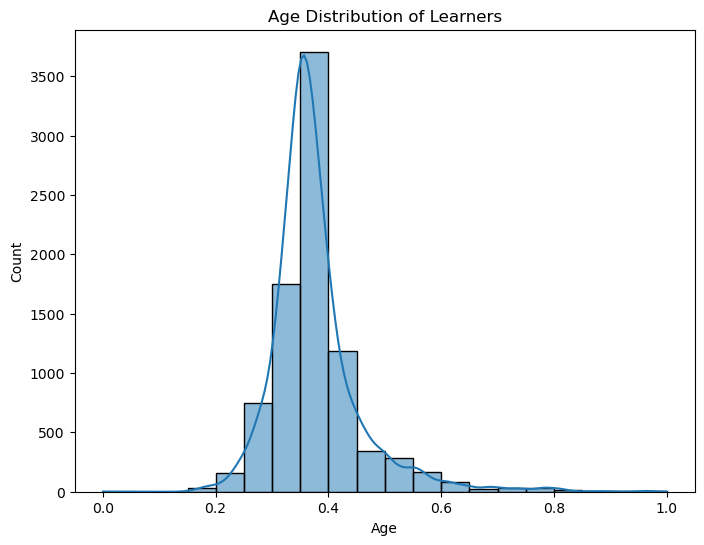

c:\Users\leewa\anaconda3\a cute anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


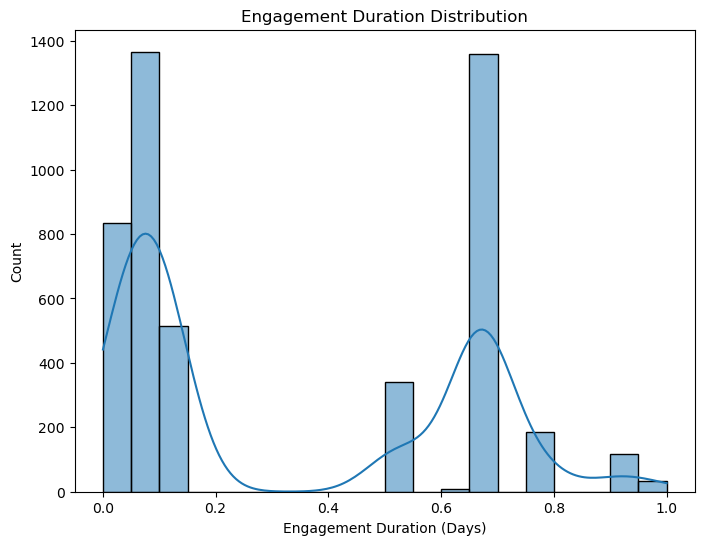

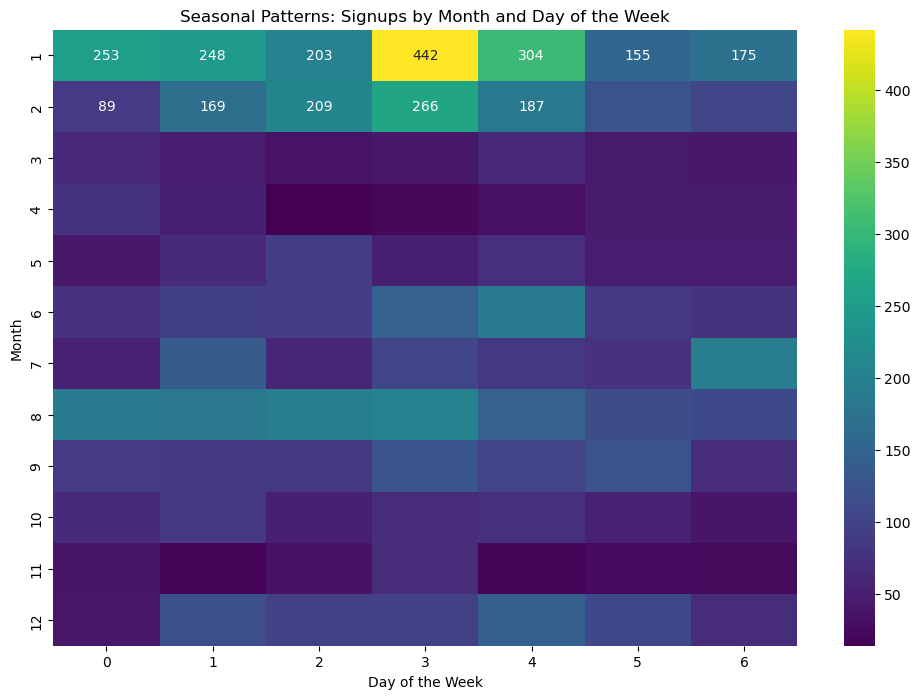

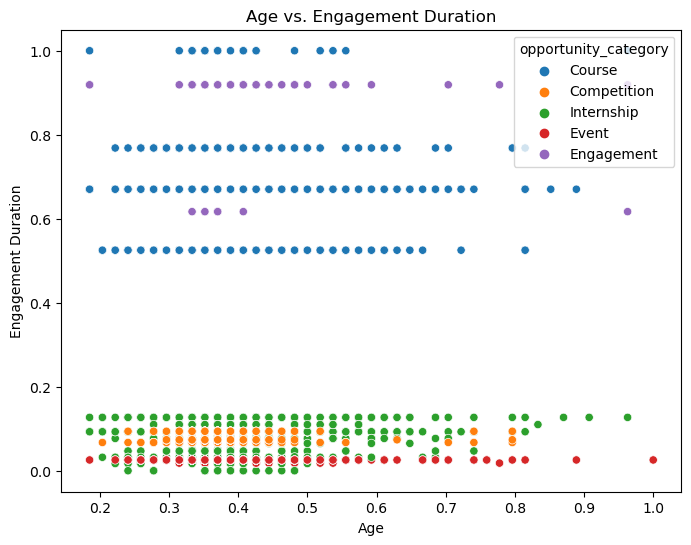

c:\Users\leewa\anaconda3\a cute anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


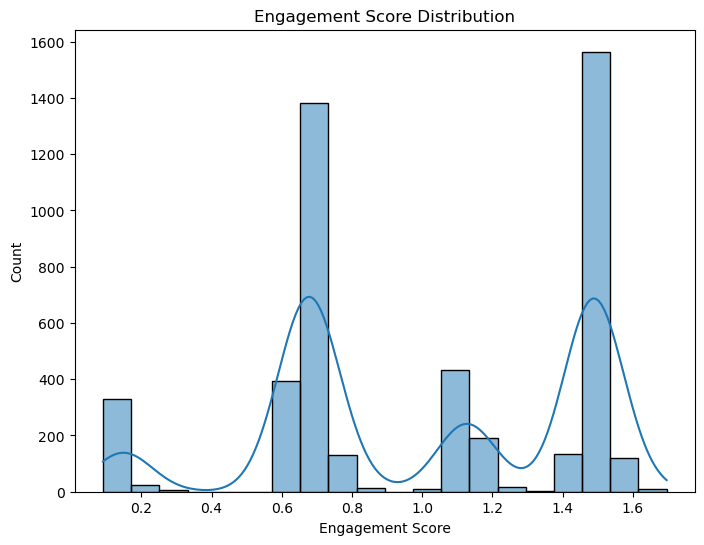

Feature engineering and visualization complete. Visualizations saved in the 'visualizations' folder.


In [ ]:
#Sourabh Vamdevan
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('cleaned dataset.csv')

def calculate_age(dob):
    if pd.isna(dob):
        return np.nan
    try:
        today = date.today()
        born = datetime.strptime(dob, "%m/%d/%Y").date()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    except ValueError:
        return np.nan

df['Age'] = df.apply(lambda x: calculate_age(x['date_of_birth']) if pd.isna(x['Age']) else x['Age'], axis=1)

bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

for col in ['learner_signup_datetime', 'opportunity_end_date', 'entry_created_at', 'apply_date', 'opportunity_start_date']:
    try:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col + '_year'] = df[col].dt.year
        df[col + '_month'] = df[col].dt.month
        df[col + '_day'] = df[col].dt.day
        df[col + '_dayofweek'] = df[col].dt.dayofweek
    except:
        print(f"Skipping column {col} as conversion is not possible")

def safe_days_diff(date1, date2):
    try:
        return abs((date1 - date2).days)
    except TypeError:
        return -9999

df['days_to_opp_end'] = df.apply(lambda row: safe_days_diff(row['learner_signup_datetime'], row['opportunity_end_date']), axis=1)
df['signup_to_apply'] = df.apply(lambda row: safe_days_diff(row['learner_signup_datetime'], row['apply_date']), axis=1)
df['signup_to_entry'] = df.apply(lambda row: safe_days_diff(row['learner_signup_datetime'], row['entry_created_at']), axis=1)

df['engagement_duration'] = (df['opportunity_end_date'] - df['opportunity_start_date']).dt.days

numeric_cols = ['days_to_opp_end', 'signup_to_apply', 'signup_to_entry', 'engagement_duration', 'Age']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df['gender'] = df['gender'].replace("Don't want to specify", "Other")
for col in ['opportunity_category', 'gender', 'country', 'current/intended_major', 'status_description', 'Status Description']:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)

for col in ['institution_name', 'Institution Name', 'current/intended_major', 'Current/Intended Major']:
    df[col] = df[col].str.lower().str.replace('[^a-zA-Z0-9\s]', '').str.strip()

df['signup_month'] = df['learner_signup_datetime'].dt.month
df['signup_dayofweek'] = df['learner_signup_datetime'].dt.dayofweek

df['age_engagement_interaction'] = df['Age'] * df['engagement_duration']

df['engagement_score'] = (df['Age'] + df['engagement_duration'] + df['opportunity_category'].astype('category').cat.codes) / 3

seasonal_signups = df.groupby(['signup_month', 'signup_dayofweek']).size().unstack()

if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

plt.figure(figsize=(8, 6))
sns.histplot(df['Age'].dropna(), kde=True, bins=20)
plt.title('Age Distribution of Learners')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('visualizations/age_distribution.png')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df['engagement_duration'].dropna(), kde=True, bins=20)
plt.title('Engagement Duration Distribution')
plt.xlabel('Engagement Duration (Days)')
plt.ylabel('Count')
plt.savefig('visualizations/engagement_duration_distribution.png')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(seasonal_signups, cmap='viridis', annot=True, fmt='d')
plt.title('Seasonal Patterns: Signups by Month and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.savefig('visualizations/seasonal_patterns.png')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='engagement_duration', data=df, hue='opportunity_category')
plt.title('Age vs. Engagement Duration')
plt.xlabel('Age')
plt.ylabel('Engagement Duration')
plt.savefig('visualizations/age_vs_engagement.png')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df['engagement_score'].dropna(), kde=True, bins=20)
plt.title('Engagement Score Distribution')
plt.xlabel('Engagement Score')
plt.ylabel('Count')
plt.savefig('visualizations/engagement_score_distribution.png')
plt.show()

df.to_csv("engineered_dataset_with_additional_features.csv", index=False)

print("Feature engineering and visualization complete. Visualizations saved in the 'visualizations' folder.")